# CSF ANALYSIS FOR PPMI data


Created: 2018-08-07    
By: Hirotaka Iwaki

Required data for this analysis:    
* "Current_Biospecimen_Analysis_Results.csv" from PPMI-LONI    
* "01_extract_EVENTDATE.csv" derived from PPMI dataset    
* "02_LatestDiagDemog.csv" derived from PPMI dataset: ([codes](https://github.com/hirotaka-i/PDcohorts/blob/master/PPMI/codes))   
* Genotypings data from LNG: Imputed and filtered (MAF >0.001, Rsq >0.3, and cut per 20K SNPs per file.)
* "PPMI.pca.eigenvec": PCs derived from genotyping data


## Objective/Model
GWAS analysis for CSF $\alpha$-synuclein concentrations.    
A linear model adjusting for sex, age, CSF hemoglobin >200, and PC1-2 with random intercept for individuals.     
After diagnosis, the CSF $\alpha$-synuclein concentrations don't change much. -> no need to think about the effect on slope.    
Patients and healthy controls are analyzed separately and meta-analized if appropriate.

## Data preparation
### CSF file
Extract $\alpha$-synuclein concentrations and CSF hemoglobin levels from "Current_Biospecimen_Analysis_Results.csv" and give the visiting date from "01_extract_EVENTDATE.csv".

In [156]:
%%bash
mkdir -p temp
awk 'BEGIN{FS=",";OFS="\t"}/CSF Alpha-synuclein/{print $1"_"$4,$7}' \
    data/Current_Biospecimen_Analysis_Results.csv | \
    sed 's/"//g' | sort > temp/asyn.txt
awk 'BEGIN{FS=",";OFS="\t"}/CSF Hemoglobin/{print $1"_"$4,$7}' \
    data/Current_Biospecimen_Analysis_Results.csv | \
    sed 's/"//g' | sort > temp/hemo.txt
awk 'BEGIN{FS=",";OFS="\t"}//{print $1"_"$2,$3}' data/01_extract_EVENTDATE.csv | \
    sed 's/"//g' | sort > temp/event_date.txt
join temp/asyn.txt temp/hemo.txt | join - temp/event_date.txt | sed 's/_/ /g' > \
    temp/asyn_hemo.txt # space separated

### Merge the above with Demographic file
merge with "02_LatestDiagDemog.csv

In [109]:
%%bash
echo '
library(dplyr)
library(data.table)
t1 = fread("data/02_LatestDiagDemog.csv", header=T)
t2 = fread("temp/asyn_hemo.txt", header=F, , na.strings="N/A") %>% 
    mutate(V1 = as.character(V1)) %>% #  V1(ID) regarded as int
    filter(!is.na(V2) & !is.na(V3)) # delete "N/A" value observation in ANSN and HEMO
names(t2)=c("ID", "EVENT_ID","ASYN", "HEMO", "DATE")
d1 = left_join(t2, t1, by = "ID")
d1 %>% mutate(HEMO_num = as.numeric(HEMO)) %>% filter(is.na(HEMO_num)) %>%
    with(table(HEMO, useNA="always"))
##############################
# The output of above line ###########
# HEMO
#   >20 above below  <NA>
#    28   314  1918     0
# Warning message:
# In evalq(as.numeric(HEMO), <environment>) : NAs introduced by coercion ((<- Warning but OK))
# ((Although, I suspect ">20" is actually "<20", I will eliminate ">20" obs in the following))
###############################
d2 = d1 %>% mutate(HEMO200 = case_when(
    HEMO==">20"~99, # for elimination
    HEMO=="below"~ 0,
    HEMO=="above"~ 1,
    TRUE~ if_else(as.numeric(HEMO)>200, 1, 0))) %>%
    mutate(logASYN = log(ASYN),
           AGE = (as.numeric(as.Date(DATE)) - BIRTHDT)/365.25) %>% 
    filter(HEMO200!=99) %>% # eliminate HEMO = ">20" obs
    mutate(CASE = case_when(
      grepl("PD_YsImg_PPMI", DIAG) ~ 1, 
      grepl("CTR_YsImg_PPMI", DIAG) ~ 0,
      TRUE ~ 99
    )) %>%
    mutate (IID = paste(ID,ID,sep="_")) # for later step to merge with Genotyping data
d2 %>% with(table(CASE), useNA="always")
d3 = d2 %>% filter(CASE!=99) %>% # num_of_obs 3200 -> 2600
    select(IID,ASYN,CASE, FEMALE,AGE,HEMO200) %>%
    arrange(IID)
write.table(d3, "temp/pheno.txt", row.names = F, quote = F, sep = "\t")
print("complete")
' > _pheno.R

In [110]:
%%bash
module load R
Rscript --vanilla _pheno.R

HEMO
  >20 above below  <NA> 
   28   314  1917     0 
CASE
   0    1   99 
 797 1747  663 
[1] "complete"


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Warning message:
In evalq(as.numeric(HEMO), <environment>) : NAs introduced by coercion
Warning message:
In if_else(as.numeric(HEMO) > 200, 1, 0) : NAs introduced by coercion


### Mege with the PCs file
merge with "PPMI.pca.eigenvec"

In [111]:
%%bash
sort temp/pheno.txt > temp/pheno_sort.txt
cut -f 2- data/PPMI.pca.eigenvec | sort | join -t$'\t' temp/pheno_sort.txt -  > temp/pheno_PC5_temp.txt
grep 'IID' temp/pheno_PC5_temp.txt > temp/pheno_PC5_colnames.txt
grep -v 'IID' temp/pheno_PC5_temp.txt | cat temp/pheno_PC5_colnames.txt - > temp/pheno_PC5.txt

## GLMM analysis

### R code for analysis

In [17]:
%%bash
echo '
args <- commandArgs(trailingOnly = TRUE)
OUTCOME = args[1]
DATASET = args[2]
chrNUM =  args[3]
ITER =  args[4]
FOLDER = args[5]
CASECODE = as.numeric(args[6])

library(data.table);library(dplyr);library(lme4)
# Read pheno.txt and set COV (PC1 and PC2)
cohort=fread("temp/pheno_PC5.txt") %>% filter(CASE==CASECODE) # Only limiting to CASE/CONTROL
COVs = names(cohort)[c(-(1:3),-9, -10, -11)] # eliminate ID, OUTCOME, CASE, PC3-5 from covariates
# Read genotyping data
SNPset = fread(paste("zcat -f ", FOLDER, "/", DATASET, "/", chrNUM, ".", ITER, ".trans.txt.gz", sep=""))
SNPs = names(SNPset)[-(1:2)] # 1 ID, 2 DOSE, SNP name starts from 3
## Merge
cohort_snp = left_join(cohort, SNPset, by = c("IID"="ID"))
write.csv(cohort_snp[,1:20], "temp/_temp.csv")
# Set function for analysis
glmm.listfunc = function(x){
  # Models
  MODEL = paste(OUTCOME, "~", "`", SNPs[x], "`+", paste(COVs, collapse="+"), "+(1|IID)", sep = "")
  testLmer = try(lmer(eval(parse(text = MODEL)), data = cohort_snp),silent = T)
  if(class(testLmer)[1]=="try-error"){
    sumstat=rep("DROP",6)
  }else{
    temp = summary(testLmer)
    temp1 = temp$coefficients
    if(grep(SNPs[x], rownames(temp1)) %>% length == 0){ # In this case, SNP is dropeed from the model
      sumstat=rep(NA,6)
    }else{
      RES = temp1[2,] # The first row is intercept
      PV_APPROX = 2 * pnorm(abs(RES[3]), lower.tail=F) # df is enough large for approximation
      OBS_N = paste(length(temp$residuals), "_", temp$ngrps, sep="")
      sumstat <- c(SNPs[x], OBS_N, RES[3], RES[1], RES[2], PV_APPROX)
    }
  }
  return(sumstat)
}
temp = lapply(1:length(SNPs), glmm.listfunc)
temp2 = do.call(rbind, temp)
attributes(temp2)$dimnames[[2]]=c("SNP", "OBS_N", "Tvalue", "Beta", "SE", "Pv_approx")
head(temp2)
NEWDIR = paste("/data/LNG/Hirotaka/ASYN/", OUTCOME, "/", chrNUM, sep = "")
dir.create(NEWDIR, recursive = T, showWarnings = F)
write.table(temp2, paste(NEWDIR, "/", DATASET, CASECODE, ".", ITER, ".txt", sep=""), row.names = F, quote = F, sep = "\t")
print("complete")
' > _analysis.R

testrun

In [19]:
%%bash
module load R
Rscript --vanilla _analysis.R ASYN PPMI chr12 11  /data/LNG/Hirotaka/progGWAS/SNPfilter/maf001rsq3_20Kcut 0

     SNP                OBS_N     Tvalue              Beta               
[1,] NA                 NA        NA                  NA                 
[2,] "12:133435793_C_T" "683_153" "-0.87889039310543" "-11836.9796570572"
[3,] "12:133435861_C_T" "683_153" "0.87369147243059"  "174.543519924414" 
[4,] "12:133436127_A_G" "683_153" "0.438184205087732" "196.729060599162" 
[5,] "12:133436499_C_T" "683_153" "0.927267980960821" "117.961539461423" 
[6,] "12:133437240_G_A" "683_153" "-1.17029526384807" "-111.174263829502"
     SE                 Pv_approx          
[1,] NA                 NA                 
[2,] "13468.0953960971" "0.379460708062466"
[3,] "199.777067113678" "0.382286296185386"
[4,] "448.964290165989" "0.661252757451634"
[5,] "127.214076063743" "0.353787414422649"
[6,] "94.9967647172634" "0.241882167195654"
[1] "complete"


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Matrix
fixed-effect model matrix is rank deficient so dropping 1 column / coefficient
There were 47 warnings (use warnings() to see them)


### Create .swarm file and submit
"swarm" is an NIH-wrapper for job arrays    
create .swirm files and then submit these jobs

In [150]:
%%bash
FOLDER=/data/LNG/Hirotaka/progGWAS/SNPfilter/maf001rsq3_20Kcut
rm _analysis*.swarm 
for j in $(ls $FOLDER/PPMI);do
    chrNUM=$(echo $j | cut -d '.' -f 1)
    ITER=$(echo $j | cut -d '.' -f 2)
    for CASECODE in 0 1;do
        if [ $CASECODE == 1 ]; then
            echo "Rscript --vanilla _analysis.R ASYN PPMI $chrNUM $ITER  $FOLDER $CASECODE" >> _analysisCASE.swarm
        else
            echo "Rscript --vanilla _analysis.R ASYN PPMI $chrNUM $ITER  $FOLDER $CASECODE" >> _analysisCTRL.swarm
        fi
    done;
done;

In [153]:
%%bash
rm -rf swarm_analysis
swarm -f  _analysisCASE.swarm --time=3:00:00 -g 3 -p 2 -b 8 --logdir ./swarm_CASE --module R --devel
swarm -f  _analysisCTRL.swarm --time=3:00:00 -g 3 -p 2 -b 8 --logdir ./swarm_CTRL --module R --devel

Loading modules R
207 commands run in 13 subjobs, each command requiring 3 gb and 1 thread, packing 2 processes per subjob, running 8 processes serially per subjob
sbatch --array=0-12 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=6144 --partition=norm --time=24:00:00 /spin1/swarm/iwakih2/S21ST0WsVw/swarm.batch
Loading modules R
207 commands run in 13 subjobs, each command requiring 3 gb and 1 thread, packing 2 processes per subjob, running 8 processes serially per subjob
sbatch --array=0-12 --job-name=swarm --output=/dev/null --error=/dev/null --cpus-per-task=2 --mem=6144 --partition=norm --time=24:00:00 /spin1/swarm/iwakih2/iDRkch3h5K/swarm.batch


In [ ]:
7052145
7052146

## results

In [1]:
%%bash
cd /data/LNG/Hirotaka/ASYN
cat ASYN/*/PPMI1.*.txt > PPMI1_all
cat ASYN/*/PPMI0.*.txt > PPMI0_all

In [2]:
%%bash
cd /data/LNG/Hirotaka/ASYN
awk '!/NA|SNP/{print $0 | "sort -gk6"}' PPMI1_all|  head

14:24775579_C_T	1528_346	6.43940750360393	2675.20657049448	415.442968782027	1.1994078161753e-10
3:184056135_A_T	1528_346	6.0193584545871	2923.62506512752	485.703765141209	1.75109704277719e-09
3:184088924_C_T	1528_346	6.01829703853742	2892.04402978057	480.541922617265	1.76261533418554e-09
3:184053802_G_A	1528_346	5.98169816625273	2870.84790205216	479.938609782884	2.2082318739328e-09
19:40117084_C_T	1528_346	5.88870982971762	468860.228296816	79620.195569952	3.89222144399269e-09
7:141755875_C_T	1528_346	5.84702079706973	5084.91950029283	869.659896342624	5.00454956982974e-09
2:112123775_G_A	1528_346	5.67898459546205	4305.03442407017	758.064113699169	1.35496680299476e-08
3:48248913_G_A	1528_346	5.6389799476042	3352.73421481869	594.56395411428	1.71060452922929e-08
6:91905187_T_A	1528_346	5.60085971507794	3083.06776498362	550.46330774609	2.13291301778489e-08
11:67192933_A_G	1528_346	5.59205096261664	2583.28850510452	461.957253675626	2.24402928021764e-08


In [3]:
%%bash
cd /data/LNG/Hirotaka/ASYN
awk '$6 < 5e-8 {print}' PPMI1_all > sign.txt

Show the p-values of the hits in the controls.

In [4]:
%%bash
cd /data/LNG/Hirotaka/ASYN
cut -f1 sign.txt > sign.list
grep -f sign.list PPMI0_all

11:5269465_A_T	683_153	-1.3729358962169	-958.808204803497	698.363417728007	0.169772276010256
11:5271582_A_T	683_153	-1.37402804241119	-959.52705000072	698.331489884961	0.169432976795903
11:5273060_G_C	683_153	-1.37571623520215	-960.688537019365	698.318819271765	0.16890950354344
11:5276380_G_C	683_153	-1.38138783642177	-964.035688747926	697.874748372679	0.167159743822198
11:5281315_T_G	683_153	-1.38278972083105	-965.584730600615	698.287466311436	0.166729351726761
11:5283903_G_C	683_153	-1.38319366857139	-965.849723533847	698.275119008759	0.166605490580032
11:5285993_C_T	683_153	-1.3799491956596	-963.597004458245	698.284406041237	0.167602287860711
11:5287551_T_C	683_153	-1.38052645388282	-963.985749946139	698.274015130143	0.167424610357538
11:61576265_C_T	683_153	-0.485387002173211	-332.629809590751	685.287838573088	0.627401850640493
11:61579702_T_C	683_153	-0.483575280436453	-516.441038050904	1067.96409771978	0.628687321634472
11:61583543_C_T	683_153	-0.48538367264413	-332.969401068503	

## meta-analysis with case and controls
Using a fixed effect model.
1. First create a input file (.toMeta)
2. Then create a processing code to pass to Metal
3. Run Metal

In [5]:
%%bash
cd /data/LNG/Hirotaka/ASYN
head PPMI1_all

SNP	OBS_N	Tvalue	Beta	SE	Pv_approx
10:125735797_G_A	1528_346	-0.332660639359814	-66.5887652406209	200.170255695916	0.739390464099567
10:125742161_G_A	1528_346	-0.283739521353135	-55.9938032171737	197.342276994559	0.776610005224595
10:125745178_A_C	1528_346	-0.3027349845545	-59.4959504601557	196.528163230652	0.762091834268502
10:125748142_C_T	1528_346	-0.500040683059406	-300.680086744558	601.311247126739	0.617046431554126
10:125749954_G_A	1528_346	-0.100768120486078	-20.117554563378	199.642054117279	0.91973453415843
10:125751614_A_G	1528_346	-0.112393394757019	-22.2810659163522	198.241773589286	0.910511492365212
10:125754242_C_T	1528_346	-0.464424428364836	-320.396292615357	689.878208481455	0.642343691608882
10:125754462_T_G	1528_346	-0.234779002516149	-44.605517875193	189.989383195054	0.814380265835604
10:125754513_A_G	1528_346	-0.236517743080789	-44.9265605278245	189.950064391062	0.813030940807411


### Create a procession script for Metal and Run

In [118]:
%%bash
cd /data/LNG/Hirotaka/ASYN
echo -e "POS REF ALT  beta se maf P" > _cols.toMeta
for DATASET in PPMI0 PPMI1;do
    tail -n +2 "$DATASET"_all | cut -f 1,4-6 | sed 's/_/\t/g' | sort > _$DATASET.toMeta
    cat _cols.toMeta $DATASET.toMeta_temp2 | sed 's/ /\t/g' > $DATASET.toMeta
done
head PPMI0.toMeta

POS	REF	ALT		beta	se	maf	P
10:100000625	G	A	-20.65804903357	83.2819755200966	0.43103	0.804096138977856
10:100000645	C	A	48.3788087575877	99.7455853922752	0.19392	0.627660701177244
10:100002399	A	G	115.418	1082.01483034701	0.00112	0.91505148762718
10:100003242	G	T	39.135227717264	191.906564242157	0.10543	0.838409332817509
10:100003304	G	A	109.252377491206	213.066835275975	0.03978	0.608118467855169
10:100003785	C	T	-14.2953665064056	82.1920681046778	0.37275	0.861923342950831
10:100004360	A	G	47.9637787830757	99.8365709951915	0.19402	0.6309266869494
10:100004441	G	C	-12.7256	82.4855500460523	0.37462	0.877391741638368
10:100004799	C	A	-259.774989231164	633.290660937207	0.01489	0.681660213685468


Note ALT is not always a minor allele.

In [119]:
%%bash
cd /data/LNG/Hirotaka/ASYN
echo "
SCHEME STDERR
" > metal.txt

for DATASET in PPMI0 PPMI1; do
    echo "
    MARKER POS
    ALLELE ALT REF
    EFFECT beta
    STDERR se
    PVALUE P
    PROCESS $DATASET.toMeta
    " >> metal.txt
done
echo "
OUTFILE metares .tbl
ANALYZE HETEROGENEITY
QUIT
" >> metal.txt
module load metal
metal metal.txt
head metares1.tbl

MetaAnalysis Helper - (c) 2007 - 2009 Goncalo Abecasis

# This program faciliates meta-analysis of genome-wide association studies.
# Commonly used commands are listed below:
#
# Options for describing input files ...
#   SEPARATOR        [WHITESPACE|COMMA|BOTH|TAB] (default = WHITESPACE)
#   COLUMNCOUNTING   [STRICT|LENIENT]            (default = 'STRICT')
#   MARKERLABEL      [LABEL]                     (default = 'MARKER')
#   ALLELELABELS     [LABEL1 LABEL2]             (default = 'ALLELE1','ALLELE2')
#   EFFECTLABEL      [LABEL|log(LABEL)]          (default = 'EFFECT')
#   FLIP
#
# Options for filtering input files ...
#   ADDFILTER        [LABEL CONDITION VALUE]     (example = ADDFILTER N > 10)
#                    (available conditions are <, >, <=, >=, =, !=, IN)
#   REMOVEFILTERS
#
# Options for sample size weighted meta-analysis ...
#   WEIGHTLABEL      [LABEL]                     (default = 'N')
#   PVALUELABEL      [LABEL]                     (default = 'PVALUE')
#   DEFAUL

[+] Loading metal  2017-12-21 


### Create a list of variants in interest

In [209]:
%%bash
cd /data/LNG/Hirotaka/ASYN
awk '$6 < 5e-8 && $8 < 0.8 {print}' metares1.tbl > metares1_sig.tbl
cut -f1 metares1_sig.tbl > _metares1_sig.pos
cut -d"_" -f1 sign.list > _sigInCase.pos
cat _metares1_sig.pos _sigInCase.pos | uniq > pull.pos
grep -f pull.pos maf001rsq3/PPMIsorted.info | LANG=C sort > pull.freq
cat pull.freq

11:5269465	0.00176	0.55272
11:5271582	0.0017	0.57382
11:5273060	0.00177	0.55091
11:5276380	0.002	0.50027
11:5281315	0.00179	0.5555
11:5283903	0.00178	0.55903
11:5285993	0.00178	0.56136
11:5287551	0.00178	0.5626
11:61576265	0.00264	0.95964
11:61579702	0.00233	0.87312
11:61583543	0.00264	0.95906
11:67192933	0.00438	0.66413
14:24775579	0.00259	0.99898
14:74075526	0.00143	0.50756
15:74777862	0.00788	0.48699
19:40117084	0.02706	0.36418
2:111891751	0.00326	0.35333
2:111959185	0.00502	0.39634
2:112123775	0.00817	0.312
3:184053802	0.00272	0.43511
3:184056135	0.0027	0.42869
3:184088924	0.00403	0.30274
3:48248913	0.00242	0.32115
6:91905187	0.00555	0.39583
7:141755875	0.0016	0.30377


These variants are significant in the case-only-analysis and/or the meta-analysis. The frequency of these alleles are all quite rare.    
Nest, pull the results of these variants from both the case-only-analysis and the meta-analysis

In [210]:
%%bash
cd /data/LNG/Hirotaka/ASYN
grep -f pull.pos metares1.tbl > _meta_pull.tab
grep -f pull.pos PPMI1_all > _PPMI1_pull.tab
grep -f pull.pos PPMI0_all > _PPMI0_pull.tab

When looking at the both files, 19:40117084 has multi-allelic results. extract 19:40117084_C_T (very rare), and join two results.

In [217]:
%%bash
cd /data/LNG/Hirotaka/ASYN
grep -v '19:40117084_C_T' _PPMI0_pull.tab | cut -f 1,4-6 | sed 's/_/\t/g' > _PPMI0_pull_join.tab
grep -v '19:40117084_C_T' _PPMI1_pull.tab | cut -f 1,4-6 | sed 's/_/\t/g' > _PPMI1_pull_join.tab
cut _meta_pull.tab -f 1-6 | sort > _meta_pull_join.tab
cut -f 1,4-6 _PPMI0_pull_join.tab | join -t$'\t' _PPMI1_pull_join.tab -  |\
    join -t$'\t' - _meta_pull_join.tab |\
    join -t$'\t' pull.freq - | LANG=C sort > _All_pull.tab
echo -e "POS\tALT_Freq\tRsq\tglmmREF\tglmmALT\tCASE_b\tCASE_se\tCASE_p\tCTRL_b\tCTRL_se\tCTRL_p\tmetaALT\tmetaREF\tMETA_b\tMETA_se\tMETAp" > _header.txt
cat _header.txt _All_pull.tab > All_pull.tab
head All_pull.tab

POS	ALT_Freq	Rsq	glmmREF	glmmALT	CASE_b	CASE_se	CASE_p	CTRL_b	CTRL_se	CTRL_p	metaALT	metaREF	META_b	META_se	METAp
11:5269465	0.00176	0.55272	A	T	8623.96646804929	1574.65777259117	4.33271502614714e-08	-958.808204803497	698.363417728007	0.169772276010256	a	t	616.2581	638.3957	0.3344
11:5271582	0.0017	0.57382	A	T	8705.10705747889	1572.56903781557	3.10171579063867e-08	-959.52705000072	698.331489884961	0.169432976795903	a	t	632.3995	638.2319	0.3218
11:5273060	0.00177	0.55091	G	C	8555.02893201884	1553.40229933502	3.64410380324682e-08	-960.688537019365	698.318819271765	0.16890950354344	c	g	-639.0354	636.9212	0.3157
11:5276380	0.002	0.50027	G	C	7930.64951813448	1426.67459574255	2.71580366715637e-08	-964.035688747926	697.874748372679	0.167159743822198	c	g	-753.3447	626.8922	0.2295
11:5281315	0.00179	0.5555	T	G	8038.21468957262	1453.51308988198	3.19870155015093e-08	-965.584730600615	698.287466311436	0.166729351726761	t	g	722.7941	629.4207	0.2508
11:5283903	0.00178	0.55903	G	C	7902.33997590934	14

In [219]:
%%bash
cd /data/LNG/Hirotaka/ASYN
LANG=C join -t$'\t' --header All_pull.tab /home/$USER/tools/rs_37_sort.txt > All_pull_rs.tab
head All_pull_rs.tab

POS	ALT_Freq	Rsq	glmmREF	glmmALT	CASE_b	CASE_se	CASE_p	CTRL_b	CTRL_se	CTRL_p	metaALT	metaREF	META_b	META_se	METAp	ID	REF	ALT
11:5269465	0.00176	0.55272	A	T	8623.96646804929	1574.65777259117	4.33271502614714e-08	-958.808204803497	698.363417728007	0.169772276010256	a	t	616.2581	638.3957	0.3344	rs2402330	A	T
11:5271582	0.0017	0.57382	A	T	8705.10705747889	1572.56903781557	3.10171579063867e-08	-959.52705000072	698.331489884961	0.169432976795903	a	t	632.3995	638.2319	0.3218	rs57966301	A	T
11:5273060	0.00177	0.55091	G	C	8555.02893201884	1553.40229933502	3.64410380324682e-08	-960.688537019365	698.318819271765	0.16890950354344	c	g	-639.0354	636.9212	0.3157	rs73402631	G	C
11:5276380	0.002	0.50027	G	C	7930.64951813448	1426.67459574255	2.71580366715637e-08	-964.035688747926	697.874748372679	0.167159743822198	c	g	-753.3447	626.8922	0.2295	rs112215533	G	C
11:5281315	0.00179	0.5555	T	G	8038.21468957262	1453.51308988198	3.19870155015093e-08	-965.584730600615	698.287466311436	0.166729351726761	t	g	722.

## Pull information from dbSNPs

In [5]:
# Preparation
from bs4 import BeautifulSoup, SoupStrainer
import requests
import re
import time
import pandas as pd
data = pd.read_table("/data/LNG/Hirotaka/ASYN/All_pull_rs.tab")
IDs = data["ID"] # dbSNP ID

SYMBOLs = []
SOTERMs = []
FXNCLASSs=[]
for ID in IDs:
    print(ID)
    response = requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=snp&id=' + ID[2:] + '&report=XML') 
    html_str = response.text 
    bs = BeautifulSoup(html_str, "html5lib") 
    try:
        SYMBOL = bs.fxnset['symbol'] 
        SOTERM = bs.fxnset['soterm']
        FXNCLASS = bs.fxnset['fxnclass']
    except (TypeError, KeyError):
        if len(bs.find_all('fxnset'))>1:
            print("search from the second tag")
            SYMBOL = bs.find_all('fxnset')[1]['symbol'] 
            SOTERM = bs.find_all('fxnset')[1]['soterm']
            FXNCLASS = bs.find_all('fxnset')[1]['fxnclass']
        else:
            SYMBOL = "NA" 
            SOTERM = "NA"
            FXNCLASS = "NA"
    SYMBOLs.append(SYMBOL)
    SOTERMs.append(SOTERM)
    FXNCLASSs.append(FXNCLASS)
    print (SYMBOL, SOTERM, FXNCLASS)
    time.sleep(1/3) # three requests per second (Guideline)


rs2402330
HBG1 500B_downstream_variant downstream-variant-500B
rs57966301
HBG1 2KB_upstream_variant upstream-variant-2KB
rs73402631
HBG1 2KB_upstream_variant upstream-variant-2KB
rs112215533
HBG2 2KB_upstream_variant upstream-variant-2KB
rs73402654
NA NA NA
rs139821845
NA NA NA
rs73402665
NA NA NA
rs73402668
NA NA NA
rs115963598
FADS1 intron_variant intron-variant
rs553545122
FADS1 intron_variant intron-variant
rs115698269
FADS2 2KB_upstream_variant upstream-variant-2KB
rs147470067
CARNS1 3_prime_UTR_variant utr-variant-3-prime
rs146737422
NOP9 3_prime_UTR_variant utr-variant-3-prime
rs148490676
HEATR4 intron_variant intron-variant
rs185007046
LOC101929333 intron_variant intron-variant
rs62122282
NA NA NA
rs138897444
MIR4435-2HG nc_transcript_variant nc-transcript-variant
rs148815166
FAM131A 5_prime_UTR_variant utr-variant-5-prime
rs149554716
FAM131A intron_variant intron-variant
rs149806004
NA NA NA
rs191029019
NA NA NA
rs145639597
NA NA NA


In [6]:
#Step3 join the cross-tab with the new information
data2= data.assign(SYMBOL=SYMBOLs, SOTERM=SOTERMs, FXNCLASS=FXNCLASSs)
## ordering the 
forIdx = data2["POS"].str.split(":", expand=True).applymap(int).sort_values(by=[0, 1])
df = data2.reindex(forIdx.index)
df.to_csv("detected.csv", index=False)

### Final result

In [37]:
df = pd.read_csv("detected.csv")
# convert META_b when REF alleles are different
df['META_b_cov'] = df['META_b'].where(df['metaREF']!=df['glmmREF'].str.lower(), -df['META_b'])

In [38]:
df.head()
df.iloc[:,[16,21,20, 0,1,2,5,6,7,8,9,10,22,14,15]]

,ID,SYMBOL,SOTERM,POS,ALT_Freq,Rsq,CASE_b,CASE_se,CASE_p,CTRL_b,CTRL_se,CTRL_p,META_b_cov,META_se,METAp
0,rs138897444,MIR4435-2HG,nc_transcript_variant,2:112123775,0.00817,0.31200,4305.034424,758.064114,1.354967e-08,-316.676144,466.821302,0.497539,954.0710,397.4973,1.639000e-02
1,rs191029019,NaN,NaN,3:48248913,0.00242,0.32115,3352.734215,594.563954,1.710605e-08,-2982.991565,7511.295280,0.691269,3313.2838,592.7100,2.270000e-08
2,rs148815166,FAM131A,5_prime_UTR_variant,3:184053802,0.00272,0.43511,2870.847902,479.938610,2.208232e-09,-3351.929746,6303.172865,0.594875,2834.9783,478.5534,3.141000e-09
3,rs149554716,FAM131A,intron_variant,3:184056135,0.00270,0.42869,2923.625065,485.703765,1.751097e-09,-3388.616924,6354.039866,0.593825,2886.9563,484.2909,2.504000e-09
4,rs149806004,NaN,NaN,3:184088924,0.00403,0.30274,2892.044030,480.541923,1.762615e-09,-830.402735,3797.258378,0.826896,2833.3694,476.7396,2.795000e-09
5,rs145639597,NaN,NaN,6:91905187,0.00555,0.39583,3083.067765,550.463308,2.132913e-08,201.720940,577.726495,0.726967,1711.9827,398.5261,1.741000e-05
6,rs2402330,HBG1,500B_downstream_variant,11:5269465,0.00176,0.55272,8623.966468,1574.657773,4.332715e-08,-958.808205,698.363418,0.169772,616.2581,638.3957,3.344000e-01
7,rs57966301,HBG1,2KB_upstream_variant,11:5271582,0.00170,0.57382,8705.107057,1572.569038,3.101716e-08,-959.527050,698.331490,0.169433,632.3995,638.2319,3.218000e-01
8,rs73402631,HBG1,2KB_upstream_variant,11:5273060,0.00177,0.55091,8555.028932,1553.402299,3.644104e-08,-960.688537,698.318819,0.168910,639.0354,636.9212,3.157000e-01
9,rs112215533,HBG2,2KB_upstream_variant,11:5276380,0.00200,0.50027,7930.649518,1426.674596,2.715804e-08,-964.035689,697.874748,0.167160,753.3447,626.8922,2.295000e-01


CASEp: P-value of the case only analysis    
METAp: P-value of the case/control meta-analysis 

In [ ]:
## QQplot and MHplot

In [206]:
%%bash
cut -f 1,6 /data/LNG/Hirotaka/ASYN/PPMI1_all | sed 's/:/\t/g' | sed 's/_/\t/g' | cut -f 1,2,5 |\
    grep -v "NA" | grep -v "SNP" > PPMI1_all.forMH
echo '
library(data.table)
data <- fread("PPMI1_all.forMH", header=F)
names(data)=c("CHR", "BP", "P")
data$P = as.numeric(data$P)
observed <- sort(data$P)
lobs <- -(log10(observed))
expected <- c(1:length(observed)) 
lexp <- -(log10(expected / (length(expected)+1)))
# alternative can also do pdf("")
png("qqplot_GWAS_RESULT.png")
# optional can change the dimensions of the plot by editing the (0,17) to smaller or bigger numbers
plot(c(0,17), c(0,17), col="red", lwd=3, type="l", xlab="Expected (-logP)", ylab="Observed (-logP)", xlim=c(0,15), ylim=c(0,15), las=1, xaxs="i", yaxs="i", bty="l")
points(lexp, lobs, pch=23, cex=.4, bg="black") 
dev.off()
chisq <- qchisq(1-data$P,1)
lambda = median(chisq)/qchisq(0.5,1)
print(lambda)
' > _QQplot.R
module load R
Rscript --vanilla _QQplot.R

null device 
          1 
[1] 0.9701559


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 


![QQplot](qqplot_GWAS_RESULT.png)
Is this a significant draft that I need to correct or do something for?
Lambda is 0.9701559

In [ ]:
%%bash
cut -f 1,6 /data/LNG/Hirotaka/ASYN/PPMI1_all | sed 's/:/\t/g' | sed 's/_/\t/g' | cut -f 1,2,5 |\
    grep -v "NA" | grep -v "SNP" > PPMI1_all.forMH
echo '
library("qqman")
require("data.table")
my_gwas = fread("tail -n +2 PPMI1_all.forMH",header=F)
names(my_gwas)=c("CHR", "BP", "P")
my_gwas$CHR=as.numeric(my_gwas$CHR)
my_gwas$BP=as.numeric(my_gwas$BP)
my_gwas$P=as.numeric(my_gwas$P)
png("manhattan_plot.png", width=2000, height=1000, pointsize=18)
manhattan(my_gwas,col = c("blue4", "orange3"), suggestiveline = T, genomewideline = F, ylab="-log(P-value)", main="CSF Alpha-synuclein levels",cex.axis = 0.6,cex = 0.5)
dev.off()
' > _MHplot.R
module load R
Rscript --vanilla _MHplot.R

![QQplot](manhattan_plot.png)

In [6]:
%%bash 
cd /data/LNG/Hirotaka/ASYN
head PPMI1_all 
# head maf001rsq3/PPMIsorted.info

SNP	OBS_N	Tvalue	Beta	SE	Pv_approx
10:125735797_G_A	1528_346	-0.332660639359814	-66.5887652406209	200.170255695916	0.739390464099567
10:125742161_G_A	1528_346	-0.283739521353135	-55.9938032171737	197.342276994559	0.776610005224595
10:125745178_A_C	1528_346	-0.3027349845545	-59.4959504601557	196.528163230652	0.762091834268502
10:125748142_C_T	1528_346	-0.500040683059406	-300.680086744558	601.311247126739	0.617046431554126
10:125749954_G_A	1528_346	-0.100768120486078	-20.117554563378	199.642054117279	0.91973453415843
10:125751614_A_G	1528_346	-0.112393394757019	-22.2810659163522	198.241773589286	0.910511492365212
10:125754242_C_T	1528_346	-0.464424428364836	-320.396292615357	689.878208481455	0.642343691608882
10:125754462_T_G	1528_346	-0.234779002516149	-44.605517875193	189.989383195054	0.814380265835604
10:125754513_A_G	1528_346	-0.236517743080789	-44.9265605278245	189.950064391062	0.813030940807411


In [14]:
%%bash 
cd /data/LNG/Hirotaka/ASYN
mkdir -p t
awk '$2>0.05 && $2<0.95 && $3>0.8 {print $0}' maf001rsq3/PPMIsorted.info |\
    LANG=C sort > maf001rsq3/PPMImaf05rsq8sorted.info

In [28]:
%%bash 
cd /data/LNG/Hirotaka/ASYN
cut -f 1,4-6 PPMI1_all | sed 's/_/\t/g' | LANG=C sort |\
    LANG=C join -t$'\t' - maf001rsq3/PPMImaf05rsq8sorted.info > PPMI1_all_maf05rsq8

In [30]:
%%bash
cut -f 1,6 /data/LNG/Hirotaka/ASYN/PPMI1_all_maf05rsq8 | sed 's/:/\t/g' |\
    grep -v "NA" | grep -v "SNP" > PPMI1_all_maf05rsq8.forMH
echo '
library("qqman")
require("data.table")
my_gwas = fread("PPMI1_all_maf05rsq8.forMH",header=F)
names(my_gwas)=c("CHR", "BP", "P")
my_gwas$CHR=as.numeric(my_gwas$CHR)
my_gwas$BP=as.numeric(my_gwas$BP)
my_gwas$P=as.numeric(my_gwas$P)
png("manhattan_plot.png", width=2000, height=1000, pointsize=18)
manhattan(my_gwas,col = c("blue4", "orange3"), suggestiveline = T, genomewideline = F, ylab="-log(P-value)", main="CSF Alpha-synuclein levels",cex.axis = 0.6,cex = 0.5)
dev.off()
' > _MHplot2.R
module load R
Rscript --vanilla _MHplot2.R

null device 
          1 


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).

Loading required package: data.table
Warning message:
In manhattan(my_gwas, col = c("blue4", "orange3"), suggestiveline = T,  :
  No SNP column found. OK unless you're trying to highlight.


MH plot for filtered (maf > 0.05, Rsq > 0.8) case only analysis 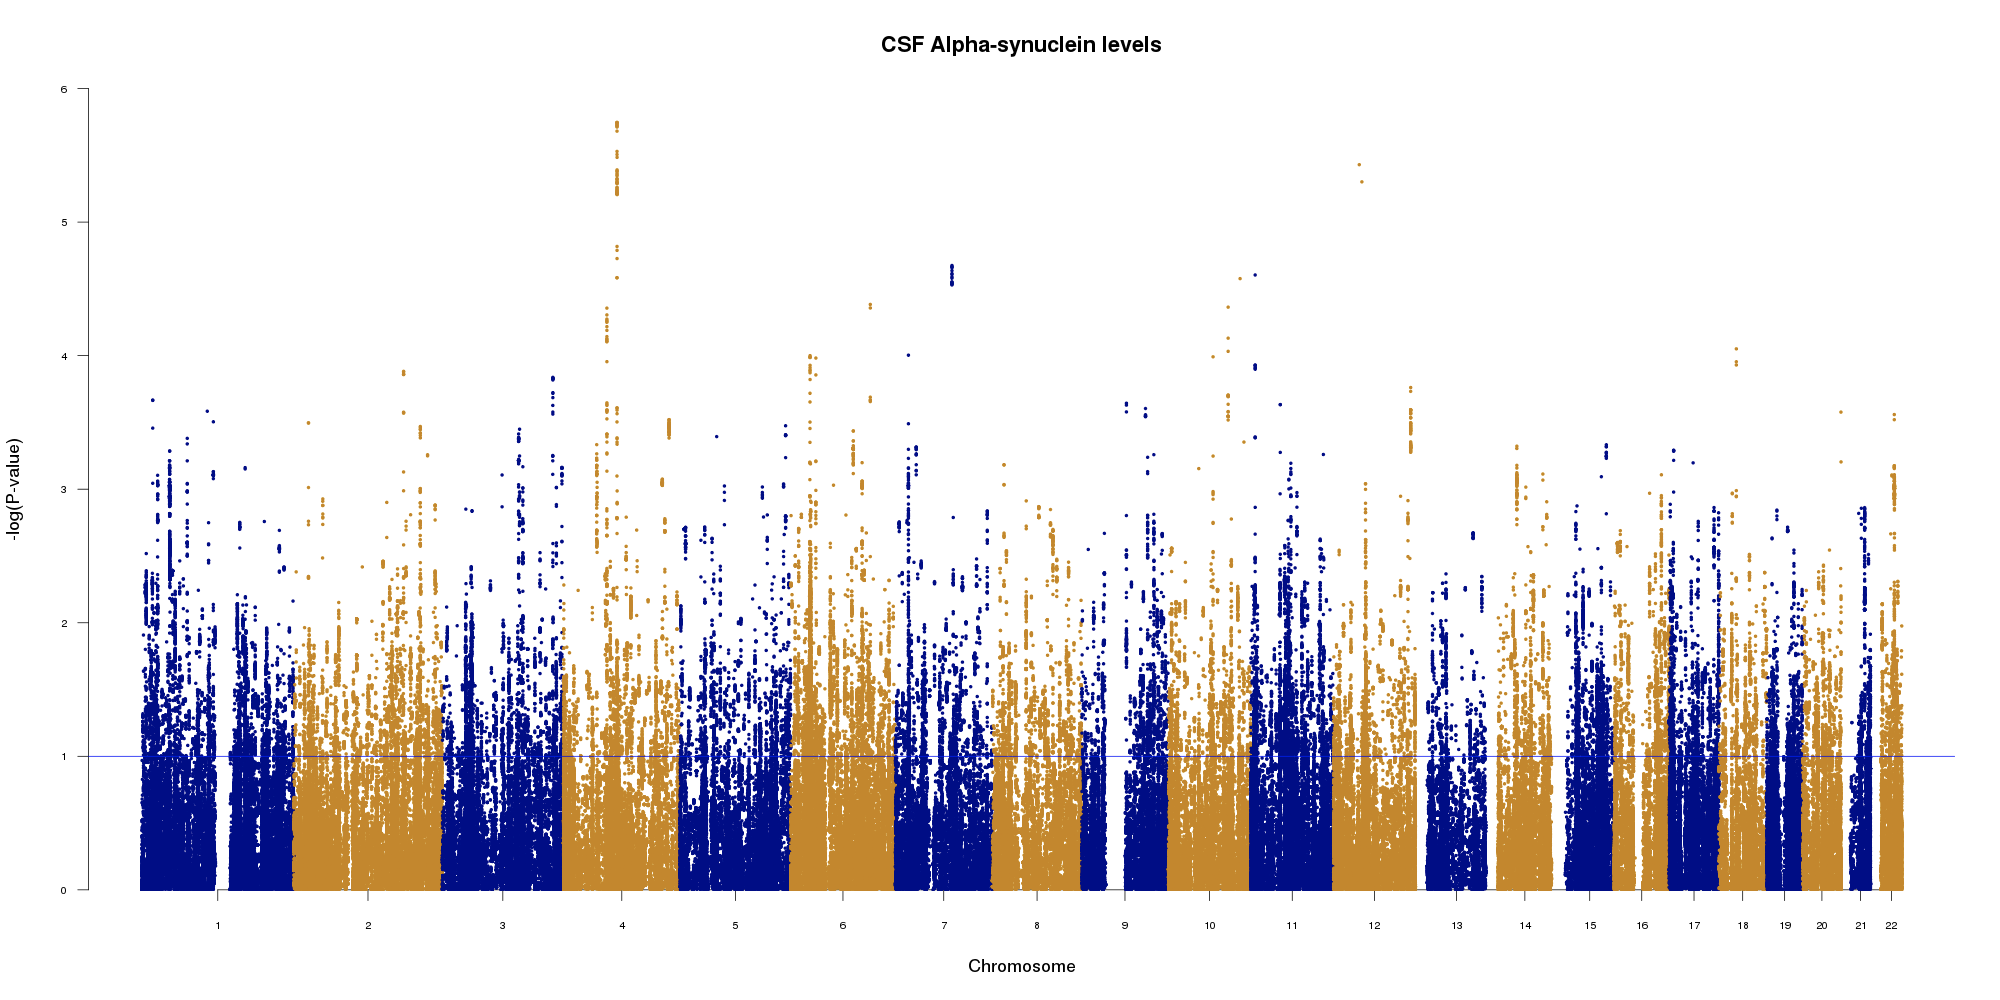